In [3]:
import os

import torch
import numpy as np

from model import model_MAF
from model.modules import data_preprocessing
from model.modules import dataset_supercell as dataset
from model.modules import loader
from model.modules import utils
from model.modules import visualizations

import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as tick
from matplotlib import cm

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['lines.linewidth']=6
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [4]:
supercells = ['/bigdata/hplsim/aipp/Anna/lwfa_10cells/'+nextfile for nextfile in os.listdir('/bigdata/hplsim/aipp/Anna/lwfa_10cells') if 'models' not in nextfile]
print(len(supercells))
models_paths = ['/bigdata/hplsim/aipp/Anna/lwfa_10cells/models/'+nextfile+'/model_1000' for nextfile in os.listdir('/bigdata/hplsim/aipp/Anna/lwfa_10cells/models')]
print(models_paths[:2])
datasets = []
models = []

for ind in range(len(supercells)):
    datasets.append(dataset.PCDataset(item_phase_space=supercells[ind],
                                   normalize=True, a=0., b=1.))
    models.append(model_MAF.PC_MAF(dim_condition=2,
                               dim_input=6,
                               num_coupling_layers=3,
                               hidden_size=64,
                               device='cpu',
                               enable_wandb=False))
    checkpoint = torch.load(models_paths[ind])
    models[-1].model.load_state_dict(checkpoint['model'])
    models[-1].vmin_ps = checkpoint['vmin_ps']
    models[-1].vmax_ps = checkpoint['vmax_ps']
    models[-1].a = checkpoint['a']
    models[-1].b = checkpoint['b']

1728
['/bigdata/hplsim/aipp/Anna/lwfa_10cells/models/RESModels_10700_44_1155_45/model_1000', '/bigdata/hplsim/aipp/Anna/lwfa_10cells/models/RESModels_10700_45_1149_50/model_1000']


In [5]:
supercells_tensors = []
file_sizes = []
for ind in range(len(supercells)):
    t = np.loadtxt(supercells[ind])
    file_sizes.append(t.shape[0])
    supercells_tensors.append(t)
all_cells = np.concatenate([arr for arr in supercells_tensors], axis=0)
print(all_cells.shape)

(848499, 6)


In [6]:
#supercell = [int(k) for k in test_pointcloud.split('/')[-1].split('.')[0].split('_')[1:]]
iteration = '10700'
pointcloud_tensor = all_cells

num_particles = 500
#idx = np.random.randint(pointcloud_tensor.shape[0], size=num_particles)
#pointcloud_tensor = pointcloud_tensor[idx, :]
radiation_tensor = torch.Tensor([0.5,0.5]).float().repeat(num_particles, 1)

labels_x = ['x', 'y', 'z']
labels_y = ['xp', 'yp', 'zp']

pred_pointclouds = []
for ind in range(len(supercells)):
    radiation_tensor = torch.Tensor([0.5,0.5]).float().repeat(file_sizes[ind], 1)
    pred_pointclouds.append((models[ind].sample_pointcloud(radiation_tensor.to(models[ind].device), radiation_tensor.shape[0])).detach().cpu().numpy())
    
    
pred_pointcloud = np.concatenate([arr for arr in pred_pointclouds], axis=0)
print(pred_pointcloud.shape)
#pred_pointcloud = pred_pointcloud_full.detach().cpu().numpy()

(848499, 6)


In [13]:
print(pred_pointcloud[0,:])
pred_pointcloud = pred_pointcloud[(pred_pointcloud[:,3] > -0.1) & (pred_pointcloud[:,3]<0.1)]
#                                 & (pred_pointcloud[:,1] > 9160) & (pred_pointcloud[:,1]<9260)
#                                 & (pred_pointcloud[:,2] > 160) & (pred_pointcloud[:,2]<240)
#                                 & (pred_pointcloud[:,0] > 300) & (pred_pointcloud[:,0]<400)]
#print(pred_pointcloud_.shape)

[ 3.5864938e+02  9.2424424e+03  1.8373608e+02 -4.0413026e-02
 -8.7932393e-02  1.9228308e-02]


NameError: name 'pred_pointcloud_' is not defined

In [52]:
print((1-pred_pointcloud_.shape[0]/pred_pointcloud.shape[0])*100)

0.4249999999999976


[ 3.28127207e-05  1.81091460e-03 -7.55517930e-03 ...  2.18987893e-02
  1.60358604e-02  2.55913548e-02]
[-0.04041303 -0.02211872 -0.02197753 ...  0.00669189  0.00948035
  0.00619634]


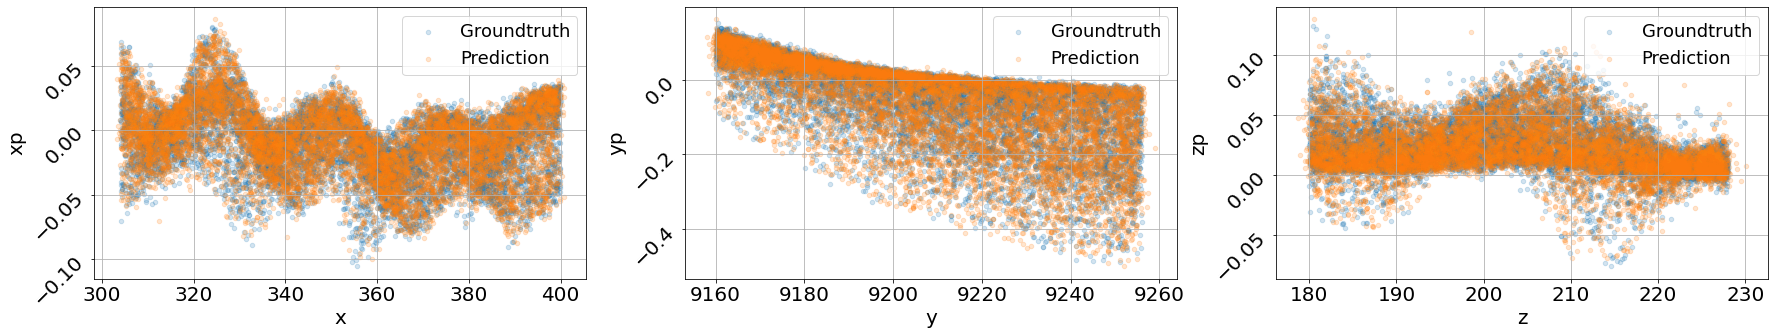

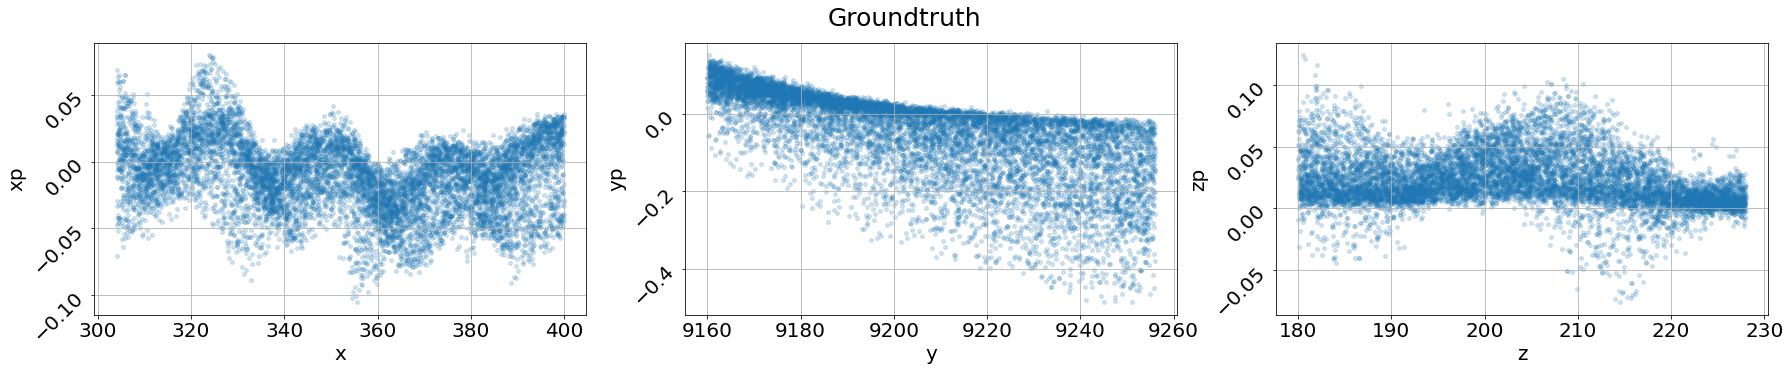

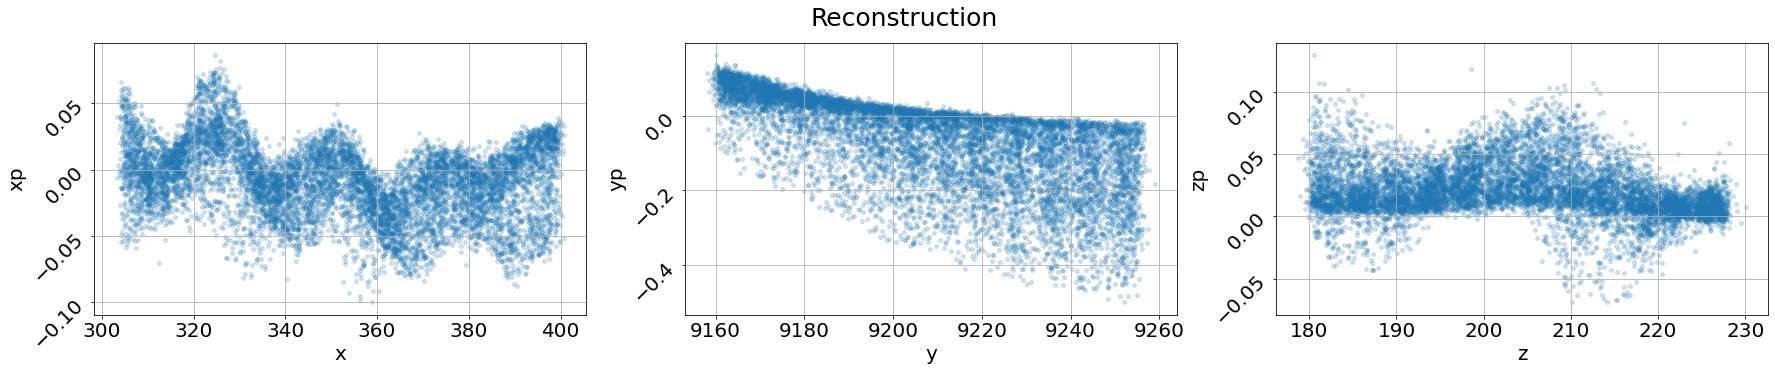

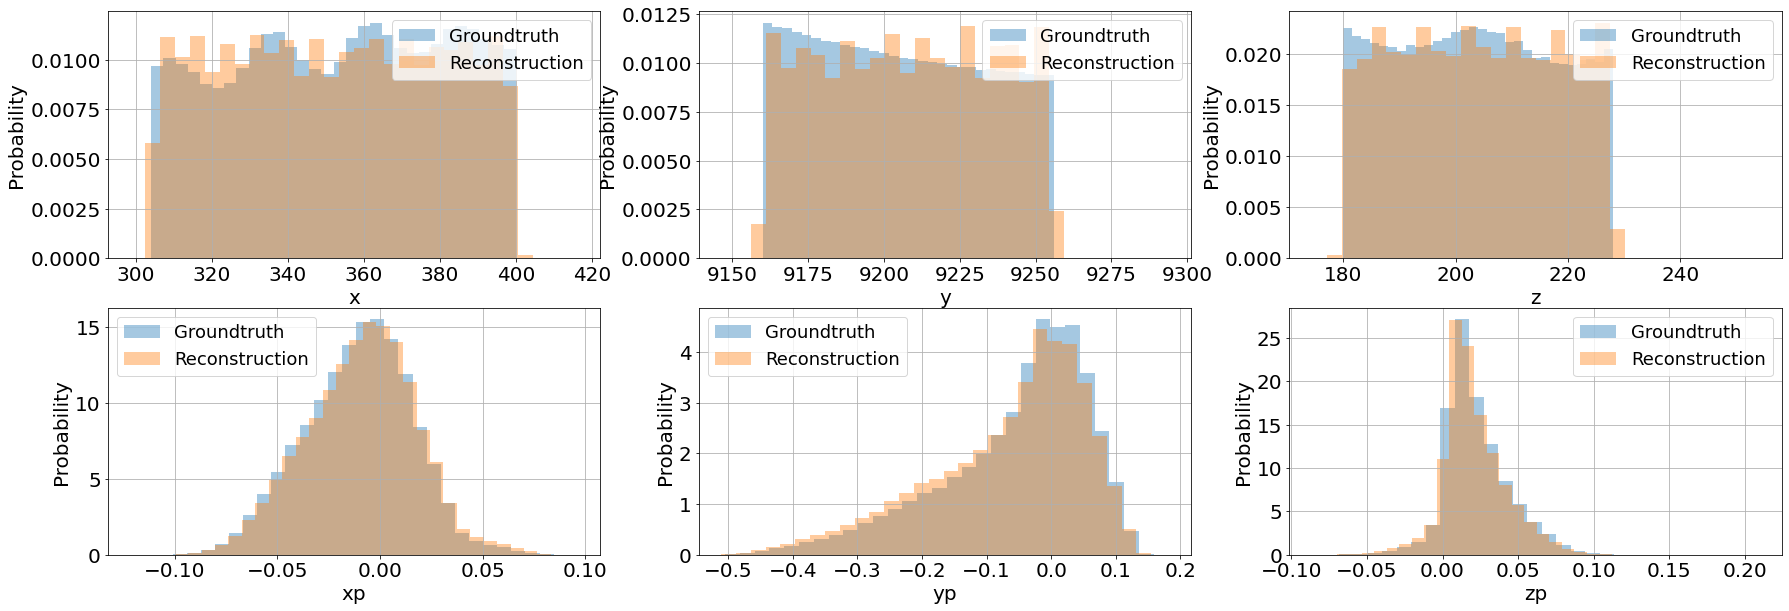

In [14]:
def plot_hist(pc, pc_pred, axs, comp_x, label_x):
    axs.hist(pc[:,comp_x], density=True, bins=30, label='Groundtruth', alpha = 0.4)  # density=False would make counts
    axs.hist(pc_pred[:,comp_x], density=True, bins=30, label='Reconstruction', alpha = 0.4)  # density=False would make counts
    if comp_x==3:
        print(pc[:,comp_x])
        print(pc_pred[:,comp_x])
    
    axs.set_ylabel('Probability')
    axs.set_xlabel(label_x)
    axs.grid(True)
    axs.legend(fontsize=18)

def plot_2D_GTandRec(pc, pc_pred, comp_x, comp_y, axs, label_x, label_y):
    axs.scatter(pc[:,comp_x], pc[:,comp_y], s=20, alpha=0.2, label='Groundtruth')
    if pc_pred is not None:
        axs.scatter(pc_pred[:,comp_x], pc_pred[:,comp_y], s=20, alpha=0.2, label='Prediction')
    axs.tick_params(axis='y', which='major', rotation=45)
    axs.grid(True)
    axs.set_xlabel(label_x)
    axs.set_ylabel(label_y)
    axs.legend(fontsize=18, loc='upper right')
    
def plot_2D(pc, comp_x, comp_y, axs, label_x, label_y):
    axs.scatter(pc[:,comp_x], pc[:,comp_y], s=15, alpha=0.2)
    axs.tick_params(axis='y', which='major', rotation=45)
    axs.grid(True)
    axs.set_xlabel(label_x)
    axs.set_ylabel(label_y)

figsize1 = 30
figsize2 = 5
fig, axs = plt.subplots(1, 3, figsize=(figsize1,figsize2))
num_particles = 10000
idx = np.random.randint(pointcloud_tensor.shape[0], size=num_particles)

for i in range(3):
    plot_2D_GTandRec(pointcloud_tensor[idx, :], pred_pointcloud[idx, :],
                     comp_x=i, comp_y=i+3, axs=axs[i],
                     label_x=labels_x[i], label_y=labels_y[i])

    
figsize1 = 30
figsize2 = 5
fig, axs = plt.subplots(1, 3, figsize=(figsize1,figsize2))
for i in range(3):
    plot_2D(pointcloud_tensor[idx, :], comp_x=i, comp_y=i+3, axs=axs[i], label_x=labels_x[i], label_y=labels_y[i])
fig.suptitle('Groundtruth', fontsize=25)

figsize1 = 30
figsize2 = 5
fig, axs = plt.subplots(1, 3, figsize=(figsize1,figsize2))
for i in range(3):
    plot_2D(pred_pointcloud[idx, :], comp_x=i, comp_y=i+3, axs=axs[i], label_x=labels_x[i], label_y=labels_y[i])
fig.suptitle('Reconstruction', fontsize=25)

figsize1 = 30
figsize2 = 10
#labels = label_x+labels_y
fig, axs = plt.subplots(2, 3, figsize=(figsize1,figsize2))
for i in range(3):
    plot_hist(pointcloud_tensor, pred_pointcloud, comp_x=i, axs=axs[0,i], label_x=labels_x[i])
for i in range(3):
    plot_hist(pointcloud_tensor, pred_pointcloud, comp_x=i+3, axs=axs[1,i], label_x=labels_y[i])

In [26]:
def plot_per_slice(pc, slice_along, num_slices, comp_of_interest, axs, label='Number of particles'):
    if comp_of_interest is not None:
        comp_of_interest = comp_of_interest - 1

    slices = [np.min(pc[:, slice_along]) + (np.max(pc[:, slice_along]) - np.min(pc[:, slice_along])) * i/num_slices for i in range(num_slices)]
    pc_ = np.concatenate((pc, np.zeros((pc.shape[0], 1))), axis=1)

    for ind in range(len(slices)-1):
        pc_[:, -1][(pc_[:, slice_along]>=slices[ind]) & (pc_[:, slice_along]<=slices[ind+1])] = ind
    pc_[:, -1][(pc_[:, slice_along]>=slices[-1])] = len(slices) - 1

    if comp_of_interest is not None:
        mean_energy = [np.mean(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if (pc_[:, comp_of_interest][pc_[:,-1]==ind]).shape[0] > 1 else None for ind in range(len(slices))]
        #std_energy = [np.std(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if pc_[:, comp_of_interest][pc_[:,-1]==ind].shape[0] > 1 else None for ind in range(len(slices)) ]
        axs.plot([slice_ for slice_ in slices], mean_energy)
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z')
        axs.set_ylabel(label)
        #axs.legend(prop={'size': 20})

    if comp_of_interest == None:
        num_particles = [pc_[pc_[:,-1]==ind].shape[0] for ind in range(len(slices))]
        axs.plot([slice_ for slice_ in slices], num_particles)
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z')
        axs.set_ylabel(label)
        #axs.legend(prop={'size': 20})

def plot_per_slice_GTandRec(pc, pc_pred, slice_along, num_slices, comp_of_interest, axs, label='Number of particles'):
    if pc_pred is not None:
        slices_pred = [np.min(pc_pred[:, slice_along]) + (np.max(pc_pred[:, slice_along]) - np.min(pc_pred[:, slice_along])) * i/num_slices for i in range(num_slices)]
        pc_pred_ = np.concatenate((pc_pred, np.zeros((pc_pred.shape[0], 1))), axis=1)

        for ind in range(len(slices_pred)-1):
            pc_pred_[:, -1][(pc_pred_[:, -3]>=slices_pred[ind]) & (pc_pred_[:, -3]<=slices_pred[ind+1])] = ind
        pc_pred_[:, -1][(pc_pred_[:, -3]>=slices_pred[-1])] = len(slices_pred) - 1
    
    if comp_of_interest is not None:
        comp_of_interest = comp_of_interest - 1

    slices = [np.min(pc[:, slice_along]) + (np.max(pc[:, slice_along]) - np.min(pc[:, slice_along])) * i/num_slices for i in range(num_slices)]
    pc_ = np.concatenate((pc, np.zeros((pc.shape[0], 1))), axis=1)

    for ind in range(len(slices)-1):
        pc_[:, -1][(pc_[:, slice_along]>=slices[ind]) & (pc_[:, slice_along]<=slices[ind+1])] = ind
    pc_[:, -1][(pc_[:, slice_along]>=slices[-1])] = len(slices) - 1

    if comp_of_interest is not None:
        mean_energy = [np.mean(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if (pc_[:, comp_of_interest][pc_[:,-1]==ind]).shape[0] > 1 else None for ind in range(len(slices))]
        std_energy = [np.std(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if pc_[:, comp_of_interest][pc_[:,-1]==ind].shape[0] > 1 else None for ind in range(len(slices)) ]

        #axs.plot([slice_ for slice_ in slices], mean_energy, label="Groundtruth")
        if pc_pred is not None:
            print('plot pred', slices_pred)
            mean_energy_pred = [np.mean(pc_pred_[:, comp_of_interest+1][pc_pred_[:,-1]==ind]) if (pc_pred_[:, comp_of_interest+1][pc_pred_[:,-1]==ind]).shape[0] > 1 else None for ind in range(len(slices_pred))]
            std_energy_pred = [np.std(pc_pred_[:, comp_of_interest+1][pc_pred_[:,-1]==ind]) if pc_pred_[:, comp_of_interest+1][pc_pred_[:,-1]==ind].shape[0] > 1 else None for ind in range(len(slices_pred)) ]
            axs.plot([slice_ for slice_ in slices_pred], mean_energy_pred, label="Reconstruction")
            
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z')
        axs.set_ylabel(label)
        axs.legend(prop={'size': 20})


    if comp_of_interest == None:
        num_particles = [pc_[pc_[:,-1]==ind].shape[0] for ind in range(len(slices))]
        axs.plot([slice_ for slice_ in slices], num_particles)
        if pc_pred is not None:
            num_particles_pred = [pc_pred_[pc_pred_[:,-1]==ind].shape[0] for ind in range(len(slices_pred))]
            axs.plot([slice_ for slice_ in slices_pred], num_particles_pred)
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z')
        axs.set_ylabel(label)
        #axs.legend(prop={'size': 20})

plot pred [202.56365966796875, 202.63222579956056, 202.70079193115234, 202.76935806274415, 202.83792419433593, 202.90649032592773, 202.97505645751954, 203.04362258911132, 203.11218872070313, 203.1807548522949, 203.24932098388672, 203.31788711547853, 203.3864532470703, 203.45501937866212, 203.5235855102539, 203.5921516418457, 203.6607177734375, 203.7292839050293, 203.7978500366211, 203.86641616821288, 203.9349822998047, 204.0035484313965, 204.07211456298828, 204.14068069458008, 204.20924682617186, 204.27781295776367, 204.34637908935548, 204.41494522094726, 204.48351135253907, 204.55207748413085, 204.62064361572266, 204.68920974731446, 204.75777587890624, 204.82634201049805, 204.89490814208983, 204.96347427368164, 205.03204040527345, 205.10060653686523, 205.16917266845704, 205.23773880004882, 205.30630493164062, 205.37487106323243, 205.4434371948242, 205.51200332641602, 205.5805694580078, 205.6491355895996, 205.71770172119142, 205.7862678527832, 205.854833984375, 205.92340011596679, 205.

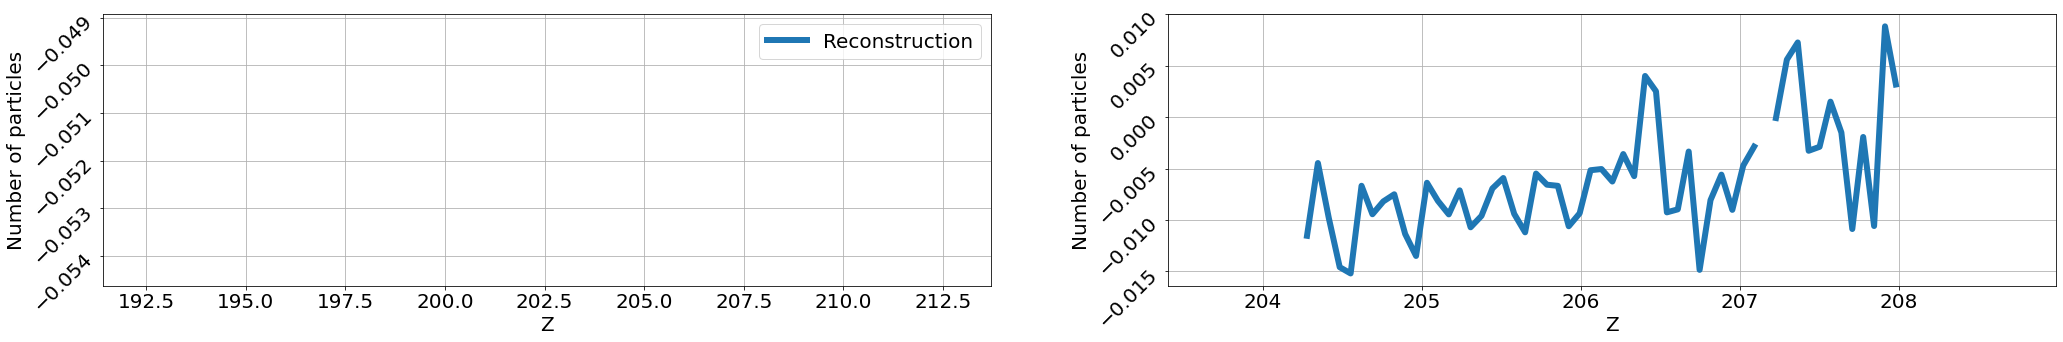

In [27]:
slice_along = 2 #z: 2
num_slices = 100
comp_of_interest = -3
figsize1 = 35
figsize2 = 5

fig, axs = plt.subplots(1, 2, figsize=(figsize1,figsize2))
plot_per_slice_GTandRec(pointcloud_tensor, pred_pointcloud,
                        slice_along, num_slices, comp_of_interest,
                        axs[0], label='Number of particles')

plot_per_slice(pred_pointcloud, slice_along, num_slices, comp_of_interest, axs[1], label='Number of particles')

#for i in range(1,4,1):
#    visualizations.plot_per_slice_GTandRec(pointcloud_tensor, pred_pointcloud,
#                        slice_along, num_slices, comp_of_interest=-1*i,
#                        axs=axs[i], label='Mean ' + labels_y[-1*i])